In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, Activation, ZeroPadding2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam
%matplotlib inline

# Definition of the model and training

## Don't forget to switch `self.noise` to True if needed

In [3]:
class autoencoder():
    def __init__(self,dataset_name='mnist',architecture='mlp'):
        
        X_train = self.load_data(dataset_name)
        optimizer = 'adadelta'

        # image parameters
        self.epochs = 4000
        self.error_list = np.zeros((self.epochs,1))
        self.img_rows = X_train.shape[1]
        self.img_cols = X_train.shape[2]
        self.img_channels = X_train.shape[3]
        self.img_size = X_train.shape[1] * X_train.shape[2] * X_train.shape[3]
        self.img_shape = (self.img_rows, self.img_cols, self.img_channels)
        self.z_dim = 10  #SWITCH TO 100 if needed
        self.architecture = architecture
        self.dataset_name = dataset_name
        self.noise = False  #SWITCH TO TRUE for denoising

        # Build and compile the autoencoder
        self.ae = self.build_ae()
        self.ae.summary()
        #binary cross-entropy loss, because mnist is grey-scale
        #you can try out the mse loss as well if you like
        self.ae.compile(optimizer=optimizer, loss='binary_crossentropy')

    def build_ae(self):

        n_pixels = self.img_rows*self.img_cols*self.img_channels

        if (self.architecture == 'mlp'):
            # FULLY CONNECTED (MLP)

            #BEGIN INSERT CODE
            #encoder
            input_img = Input(shape=(self.img_rows,self.img_cols,self.img_channels))
            z = Flatten()(input_img)
            z = Dense(self.z_dim)(z)
            z = LeakyReLU(alpha=0.2)(z)
            #decoder
            #output_img = Input(shape=self.z_dim)
            output_img = Dense(n_pixels)(z)
            output_img = Activation('sigmoid')(output_img)
            output_img = Reshape((self.img_rows,self.img_cols,self.img_channels))(output_img)


            #END INSERT CODE
        elif(self.architecture == 'convolutional'):
            # CONVOLUTIONAL MODEL

            #BEGIN INSERT CODE
            #encoder
            input_img = Input(shape=(self.img_rows,self.img_cols,self.img_channels))
            z = Conv2D(8, (3,3), strides=(2,2), padding='same')(input_img)
            z = LeakyReLU(alpha=0.2)(z)
            z = Conv2D(4, (3,3), strides=(2,2), padding='same')(z)
            z = LeakyReLU(alpha=0.2)(z)
            z = Flatten()(z)
            z = Dense(self.z_dim)(z)
            #decoder
            output_img = Dense(196)(z)
            output_img = LeakyReLU(alpha=0.2)(output_img)
            output_img = Reshape((7,7,4))(output_img)
            output_img = Conv2DTranspose(4, (3,3), strides=(2,2), padding='same')(output_img)
            output_img = LeakyReLU(alpha=0.2)(output_img)
            output_img = Conv2DTranspose(1, (3,3), strides=(2,2), padding='same')(output_img)
            output_img = Activation('sigmoid')(output_img)
            
            #END INSERTs CODE

        #output the model
        return Model(input_img, output_img)


    def load_data(self,dataset_name):
        # Load the dataset
        if(dataset_name == 'mnist'):
            (X_train, _), (_, _) = mnist.load_data()
        else:
            print('Error, unknown database')

        # normalise images between 0 and 1
        X_train = X_train/255.0
        #add a channel dimension, if need be (for mnist data)
        if(X_train.ndim ==3):
            X_train = np.expand_dims(X_train, axis=3)
        return X_train

    def train(self, epochs, batch_size=128, sample_interval=50):
        
        #load dataset
        X_train = self.load_data(self.dataset_name)

        sigma = 20.0/255.0

        for i in range(0,epochs):

            # ---------------------
            #  Autoencoder
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            curr_batch = X_train[idx,:,:,:]
            # Autoencoder training
            if self.noise:
                noise = np.expand_dims(np.random.normal(scale=20/255, size=(self.img_rows,self.img_rows)), axis=2)
                loss = self.ae.train_on_batch(curr_batch+noise,curr_batch)
            else:
                loss = self.ae.train_on_batch(curr_batch,curr_batch)
                
            # print the losses
            print("%d [Loss: %f]" % (i, loss))
            self.error_list[i] = loss

            # Save some random generated images and the models at every sample_interval iterations
            if (i % sample_interval == 0):
                n_images = 5
                idx = np.random.randint(0, X_train.shape[0], n_images)
                test_imgs = X_train[idx,:,:,:]
                noise = np.expand_dims(np.random.normal(scale=20/255, size=(n_images,self.img_rows,self.img_rows)),
                                   axis=3)
                curr_batch = test_imgs + noise
                self.test_images(curr_batch,'images/'+self.dataset_name+self.architecture+str(self.z_dim)+'_reconstruction_%06d.png' % i)
        self.ae.save('ae_'+self.architecture+'.h5')
        
    def test_images(self, test_imgs, image_filename):
        n_images = test_imgs.shape[0]
        #get output imagesq
        output_imgs = self.ae.predict( test_imgs )
        
        r = 2
        c = n_images
        fig, axs = plt.subplots(r, c)
        for j in range(c):
            #black and white images
            axs[0,j].imshow(test_imgs[j, :,:,0], cmap='gray')
            axs[0,j].axis('off')
            axs[1,j].imshow(output_imgs[j, :,:,0], cmap='gray')
            axs[1,j].axis('off')
        fig.savefig(image_filename)
        plt.close()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                7850      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 784)               8624      
_________________________________________________________________
activation_1 (Activation)    (None, 784)               0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
Total para

346 [Loss: 0.266350]
347 [Loss: 0.281294]
348 [Loss: 0.269266]
349 [Loss: 0.284020]
350 [Loss: 0.273591]
351 [Loss: 0.282868]
352 [Loss: 0.264144]
353 [Loss: 0.286415]
354 [Loss: 0.272452]
355 [Loss: 0.284517]
356 [Loss: 0.265818]
357 [Loss: 0.261678]
358 [Loss: 0.267005]
359 [Loss: 0.270886]
360 [Loss: 0.269366]
361 [Loss: 0.256622]
362 [Loss: 0.279204]
363 [Loss: 0.259720]
364 [Loss: 0.269705]
365 [Loss: 0.260059]
366 [Loss: 0.288656]
367 [Loss: 0.266347]
368 [Loss: 0.271061]
369 [Loss: 0.279812]
370 [Loss: 0.269269]
371 [Loss: 0.273337]
372 [Loss: 0.271279]
373 [Loss: 0.254404]
374 [Loss: 0.291642]
375 [Loss: 0.259241]
376 [Loss: 0.267892]
377 [Loss: 0.274771]
378 [Loss: 0.267175]
379 [Loss: 0.262372]
380 [Loss: 0.278100]
381 [Loss: 0.266849]
382 [Loss: 0.275975]
383 [Loss: 0.270497]
384 [Loss: 0.268210]
385 [Loss: 0.273196]
386 [Loss: 0.256984]
387 [Loss: 0.266405]
388 [Loss: 0.268039]
389 [Loss: 0.263206]
390 [Loss: 0.269323]
391 [Loss: 0.267734]
392 [Loss: 0.280939]
393 [Loss: 0.

746 [Loss: 0.246927]
747 [Loss: 0.243750]
748 [Loss: 0.257010]
749 [Loss: 0.249260]
750 [Loss: 0.256830]
751 [Loss: 0.256125]
752 [Loss: 0.277622]
753 [Loss: 0.267506]
754 [Loss: 0.263613]
755 [Loss: 0.250376]
756 [Loss: 0.244207]
757 [Loss: 0.243517]
758 [Loss: 0.245389]
759 [Loss: 0.258792]
760 [Loss: 0.254683]
761 [Loss: 0.263516]
762 [Loss: 0.251023]
763 [Loss: 0.245141]
764 [Loss: 0.247887]
765 [Loss: 0.268408]
766 [Loss: 0.247936]
767 [Loss: 0.248667]
768 [Loss: 0.243313]
769 [Loss: 0.237462]
770 [Loss: 0.255900]
771 [Loss: 0.258786]
772 [Loss: 0.246631]
773 [Loss: 0.262514]
774 [Loss: 0.258418]
775 [Loss: 0.253562]
776 [Loss: 0.241961]
777 [Loss: 0.242995]
778 [Loss: 0.255672]
779 [Loss: 0.247839]
780 [Loss: 0.242678]
781 [Loss: 0.248015]
782 [Loss: 0.251789]
783 [Loss: 0.256277]
784 [Loss: 0.252505]
785 [Loss: 0.253478]
786 [Loss: 0.240209]
787 [Loss: 0.253940]
788 [Loss: 0.233289]
789 [Loss: 0.248802]
790 [Loss: 0.258181]
791 [Loss: 0.253404]
792 [Loss: 0.270110]
793 [Loss: 0.

1148 [Loss: 0.227188]
1149 [Loss: 0.230538]
1150 [Loss: 0.231281]
1151 [Loss: 0.224325]
1152 [Loss: 0.235790]
1153 [Loss: 0.226286]
1154 [Loss: 0.231284]
1155 [Loss: 0.217112]
1156 [Loss: 0.218581]
1157 [Loss: 0.237695]
1158 [Loss: 0.230582]
1159 [Loss: 0.233940]
1160 [Loss: 0.237836]
1161 [Loss: 0.241261]
1162 [Loss: 0.221348]
1163 [Loss: 0.233638]
1164 [Loss: 0.227460]
1165 [Loss: 0.223818]
1166 [Loss: 0.222828]
1167 [Loss: 0.224518]
1168 [Loss: 0.235691]
1169 [Loss: 0.229369]
1170 [Loss: 0.229804]
1171 [Loss: 0.222941]
1172 [Loss: 0.217790]
1173 [Loss: 0.227327]
1174 [Loss: 0.235952]
1175 [Loss: 0.212392]
1176 [Loss: 0.233506]
1177 [Loss: 0.218261]
1178 [Loss: 0.231042]
1179 [Loss: 0.240114]
1180 [Loss: 0.216561]
1181 [Loss: 0.236993]
1182 [Loss: 0.227860]
1183 [Loss: 0.225494]
1184 [Loss: 0.238365]
1185 [Loss: 0.225600]
1186 [Loss: 0.229003]
1187 [Loss: 0.211004]
1188 [Loss: 0.232411]
1189 [Loss: 0.226327]
1190 [Loss: 0.242750]
1191 [Loss: 0.223591]
1192 [Loss: 0.230622]
1193 [Loss

1546 [Loss: 0.205895]
1547 [Loss: 0.222079]
1548 [Loss: 0.208715]
1549 [Loss: 0.203334]
1550 [Loss: 0.209817]
1551 [Loss: 0.221389]
1552 [Loss: 0.206832]
1553 [Loss: 0.207361]
1554 [Loss: 0.200046]
1555 [Loss: 0.223125]
1556 [Loss: 0.212339]
1557 [Loss: 0.203036]
1558 [Loss: 0.228780]
1559 [Loss: 0.212596]
1560 [Loss: 0.213170]
1561 [Loss: 0.198725]
1562 [Loss: 0.206831]
1563 [Loss: 0.218289]
1564 [Loss: 0.207758]
1565 [Loss: 0.213853]
1566 [Loss: 0.218312]
1567 [Loss: 0.203110]
1568 [Loss: 0.228395]
1569 [Loss: 0.212831]
1570 [Loss: 0.218324]
1571 [Loss: 0.213851]
1572 [Loss: 0.218128]
1573 [Loss: 0.221696]
1574 [Loss: 0.215653]
1575 [Loss: 0.207283]
1576 [Loss: 0.202124]
1577 [Loss: 0.209120]
1578 [Loss: 0.204879]
1579 [Loss: 0.210503]
1580 [Loss: 0.214408]
1581 [Loss: 0.211401]
1582 [Loss: 0.206695]
1583 [Loss: 0.215138]
1584 [Loss: 0.211525]
1585 [Loss: 0.216450]
1586 [Loss: 0.226941]
1587 [Loss: 0.211525]
1588 [Loss: 0.213923]
1589 [Loss: 0.205945]
1590 [Loss: 0.222022]
1591 [Loss

1949 [Loss: 0.204539]
1950 [Loss: 0.196357]
1951 [Loss: 0.201217]
1952 [Loss: 0.210247]
1953 [Loss: 0.200705]
1954 [Loss: 0.201730]
1955 [Loss: 0.198065]
1956 [Loss: 0.196812]
1957 [Loss: 0.200949]
1958 [Loss: 0.192170]
1959 [Loss: 0.206535]
1960 [Loss: 0.193996]
1961 [Loss: 0.195320]
1962 [Loss: 0.201828]
1963 [Loss: 0.211877]
1964 [Loss: 0.195512]
1965 [Loss: 0.208455]
1966 [Loss: 0.189799]
1967 [Loss: 0.197136]
1968 [Loss: 0.205347]
1969 [Loss: 0.206345]
1970 [Loss: 0.199327]
1971 [Loss: 0.193533]
1972 [Loss: 0.197741]
1973 [Loss: 0.210580]
1974 [Loss: 0.198185]
1975 [Loss: 0.205285]
1976 [Loss: 0.198360]
1977 [Loss: 0.197231]
1978 [Loss: 0.187032]
1979 [Loss: 0.188576]
1980 [Loss: 0.192740]
1981 [Loss: 0.195498]
1982 [Loss: 0.184269]
1983 [Loss: 0.193972]
1984 [Loss: 0.213100]
1985 [Loss: 0.205253]
1986 [Loss: 0.206659]
1987 [Loss: 0.207538]
1988 [Loss: 0.188928]
1989 [Loss: 0.197947]
1990 [Loss: 0.208200]
1991 [Loss: 0.193848]
1992 [Loss: 0.197229]
1993 [Loss: 0.214203]
1994 [Loss

2347 [Loss: 0.194892]
2348 [Loss: 0.180142]
2349 [Loss: 0.180726]
2350 [Loss: 0.190522]
2351 [Loss: 0.188258]
2352 [Loss: 0.196550]
2353 [Loss: 0.194506]
2354 [Loss: 0.199928]
2355 [Loss: 0.196240]
2356 [Loss: 0.197647]
2357 [Loss: 0.185057]
2358 [Loss: 0.200833]
2359 [Loss: 0.190518]
2360 [Loss: 0.189417]
2361 [Loss: 0.191058]
2362 [Loss: 0.193937]
2363 [Loss: 0.194420]
2364 [Loss: 0.195137]
2365 [Loss: 0.192747]
2366 [Loss: 0.200483]
2367 [Loss: 0.185006]
2368 [Loss: 0.185254]
2369 [Loss: 0.193971]
2370 [Loss: 0.189263]
2371 [Loss: 0.200893]
2372 [Loss: 0.187552]
2373 [Loss: 0.202328]
2374 [Loss: 0.193478]
2375 [Loss: 0.187112]
2376 [Loss: 0.203719]
2377 [Loss: 0.197979]
2378 [Loss: 0.186787]
2379 [Loss: 0.183216]
2380 [Loss: 0.197286]
2381 [Loss: 0.195994]
2382 [Loss: 0.190723]
2383 [Loss: 0.196367]
2384 [Loss: 0.193717]
2385 [Loss: 0.199946]
2386 [Loss: 0.190474]
2387 [Loss: 0.190979]
2388 [Loss: 0.189907]
2389 [Loss: 0.189027]
2390 [Loss: 0.178916]
2391 [Loss: 0.195690]
2392 [Loss

2755 [Loss: 0.191277]
2756 [Loss: 0.197124]
2757 [Loss: 0.200597]
2758 [Loss: 0.191710]
2759 [Loss: 0.193565]
2760 [Loss: 0.187405]
2761 [Loss: 0.191060]
2762 [Loss: 0.196565]
2763 [Loss: 0.180712]
2764 [Loss: 0.193893]
2765 [Loss: 0.186059]
2766 [Loss: 0.186260]
2767 [Loss: 0.193345]
2768 [Loss: 0.188798]
2769 [Loss: 0.198612]
2770 [Loss: 0.182577]
2771 [Loss: 0.198042]
2772 [Loss: 0.189582]
2773 [Loss: 0.200360]
2774 [Loss: 0.187780]
2775 [Loss: 0.188199]
2776 [Loss: 0.178430]
2777 [Loss: 0.174186]
2778 [Loss: 0.196640]
2779 [Loss: 0.192238]
2780 [Loss: 0.187017]
2781 [Loss: 0.192685]
2782 [Loss: 0.190440]
2783 [Loss: 0.203493]
2784 [Loss: 0.174701]
2785 [Loss: 0.186038]
2786 [Loss: 0.183752]
2787 [Loss: 0.186624]
2788 [Loss: 0.186487]
2789 [Loss: 0.188041]
2790 [Loss: 0.191058]
2791 [Loss: 0.183805]
2792 [Loss: 0.190289]
2793 [Loss: 0.197811]
2794 [Loss: 0.189158]
2795 [Loss: 0.193987]
2796 [Loss: 0.186623]
2797 [Loss: 0.189825]
2798 [Loss: 0.184521]
2799 [Loss: 0.193482]
2800 [Loss

3148 [Loss: 0.184556]
3149 [Loss: 0.185173]
3150 [Loss: 0.179106]
3151 [Loss: 0.187134]
3152 [Loss: 0.177694]
3153 [Loss: 0.200180]
3154 [Loss: 0.172747]
3155 [Loss: 0.178662]
3156 [Loss: 0.189379]
3157 [Loss: 0.181563]
3158 [Loss: 0.173923]
3159 [Loss: 0.181426]
3160 [Loss: 0.201024]
3161 [Loss: 0.174284]
3162 [Loss: 0.183441]
3163 [Loss: 0.179279]
3164 [Loss: 0.180532]
3165 [Loss: 0.176126]
3166 [Loss: 0.184628]
3167 [Loss: 0.172508]
3168 [Loss: 0.191292]
3169 [Loss: 0.180164]
3170 [Loss: 0.185690]
3171 [Loss: 0.180373]
3172 [Loss: 0.194877]
3173 [Loss: 0.187842]
3174 [Loss: 0.183007]
3175 [Loss: 0.184087]
3176 [Loss: 0.173381]
3177 [Loss: 0.198183]
3178 [Loss: 0.193415]
3179 [Loss: 0.185872]
3180 [Loss: 0.179947]
3181 [Loss: 0.183369]
3182 [Loss: 0.181623]
3183 [Loss: 0.179513]
3184 [Loss: 0.187114]
3185 [Loss: 0.183052]
3186 [Loss: 0.174091]
3187 [Loss: 0.190338]
3188 [Loss: 0.180407]
3189 [Loss: 0.183247]
3190 [Loss: 0.183377]
3191 [Loss: 0.182140]
3192 [Loss: 0.176525]
3193 [Loss

3547 [Loss: 0.179137]
3548 [Loss: 0.181979]
3549 [Loss: 0.171285]
3550 [Loss: 0.179640]
3551 [Loss: 0.161120]
3552 [Loss: 0.188681]
3553 [Loss: 0.181799]
3554 [Loss: 0.185238]
3555 [Loss: 0.167050]
3556 [Loss: 0.174815]
3557 [Loss: 0.166851]
3558 [Loss: 0.177709]
3559 [Loss: 0.172357]
3560 [Loss: 0.176844]
3561 [Loss: 0.175773]
3562 [Loss: 0.177150]
3563 [Loss: 0.175792]
3564 [Loss: 0.178774]
3565 [Loss: 0.187315]
3566 [Loss: 0.174928]
3567 [Loss: 0.177714]
3568 [Loss: 0.181544]
3569 [Loss: 0.177269]
3570 [Loss: 0.178271]
3571 [Loss: 0.181529]
3572 [Loss: 0.198208]
3573 [Loss: 0.176030]
3574 [Loss: 0.185876]
3575 [Loss: 0.180736]
3576 [Loss: 0.185802]
3577 [Loss: 0.179133]
3578 [Loss: 0.180882]
3579 [Loss: 0.173119]
3580 [Loss: 0.167287]
3581 [Loss: 0.185720]
3582 [Loss: 0.177881]
3583 [Loss: 0.182310]
3584 [Loss: 0.176687]
3585 [Loss: 0.169672]
3586 [Loss: 0.173265]
3587 [Loss: 0.190172]
3588 [Loss: 0.179402]
3589 [Loss: 0.173221]
3590 [Loss: 0.180481]
3591 [Loss: 0.180916]
3592 [Loss

3948 [Loss: 0.176073]
3949 [Loss: 0.175686]
3950 [Loss: 0.170646]
3951 [Loss: 0.182261]
3952 [Loss: 0.173820]
3953 [Loss: 0.180843]
3954 [Loss: 0.181817]
3955 [Loss: 0.176847]
3956 [Loss: 0.167856]
3957 [Loss: 0.173770]
3958 [Loss: 0.169363]
3959 [Loss: 0.190528]
3960 [Loss: 0.191145]
3961 [Loss: 0.179893]
3962 [Loss: 0.178619]
3963 [Loss: 0.175011]
3964 [Loss: 0.176519]
3965 [Loss: 0.185487]
3966 [Loss: 0.174888]
3967 [Loss: 0.175088]
3968 [Loss: 0.178302]
3969 [Loss: 0.179744]
3970 [Loss: 0.178864]
3971 [Loss: 0.183247]
3972 [Loss: 0.172230]
3973 [Loss: 0.172701]
3974 [Loss: 0.180135]
3975 [Loss: 0.184415]
3976 [Loss: 0.161384]
3977 [Loss: 0.173670]
3978 [Loss: 0.164701]
3979 [Loss: 0.171967]
3980 [Loss: 0.166679]
3981 [Loss: 0.168849]
3982 [Loss: 0.164618]
3983 [Loss: 0.175980]
3984 [Loss: 0.179250]
3985 [Loss: 0.173343]
3986 [Loss: 0.169382]
3987 [Loss: 0.168462]
3988 [Loss: 0.165687]
3989 [Loss: 0.178603]
3990 [Loss: 0.179064]
3991 [Loss: 0.168683]
3992 [Loss: 0.183896]
3993 [Loss

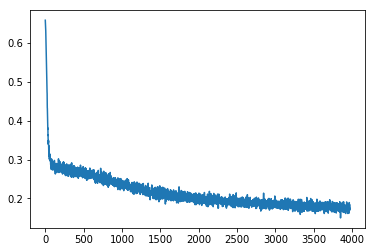

In [4]:
if __name__ == '__main__':

	#create the output image directory
	if (os.path.isdir('images')==0):
		os.mkdir('images')

	#choose dataset
	dataset_name = 'mnist'#

	#create AE model
	architecture = 'mlp'#'convolutional'#
	ae_mlp = autoencoder(dataset_name,architecture)#,

	ae_mlp.train(epochs=ae_mlp.epochs, batch_size=64, sample_interval=100)
	plt.plot(ae_mlp.error_list[30:])
	plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         80        
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 4)           292       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 7, 7, 4)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 196)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1970      
__________

301 [Loss: 0.211730]
302 [Loss: 0.216412]
303 [Loss: 0.215424]
304 [Loss: 0.234746]
305 [Loss: 0.219345]
306 [Loss: 0.214238]
307 [Loss: 0.220035]
308 [Loss: 0.222438]
309 [Loss: 0.227910]
310 [Loss: 0.223023]
311 [Loss: 0.205085]
312 [Loss: 0.230076]
313 [Loss: 0.214116]
314 [Loss: 0.206084]
315 [Loss: 0.221537]
316 [Loss: 0.213011]
317 [Loss: 0.212103]
318 [Loss: 0.213447]
319 [Loss: 0.218651]
320 [Loss: 0.212402]
321 [Loss: 0.219738]
322 [Loss: 0.221878]
323 [Loss: 0.205430]
324 [Loss: 0.209529]
325 [Loss: 0.219450]
326 [Loss: 0.215352]
327 [Loss: 0.201587]
328 [Loss: 0.207865]
329 [Loss: 0.206956]
330 [Loss: 0.205009]
331 [Loss: 0.207306]
332 [Loss: 0.208687]
333 [Loss: 0.216363]
334 [Loss: 0.208211]
335 [Loss: 0.208277]
336 [Loss: 0.201389]
337 [Loss: 0.211807]
338 [Loss: 0.204681]
339 [Loss: 0.211263]
340 [Loss: 0.202690]
341 [Loss: 0.219450]
342 [Loss: 0.206350]
343 [Loss: 0.215812]
344 [Loss: 0.209663]
345 [Loss: 0.204634]
346 [Loss: 0.208386]
347 [Loss: 0.198724]
348 [Loss: 0.

701 [Loss: 0.162331]
702 [Loss: 0.173044]
703 [Loss: 0.166843]
704 [Loss: 0.161722]
705 [Loss: 0.169714]
706 [Loss: 0.163059]
707 [Loss: 0.158214]
708 [Loss: 0.160780]
709 [Loss: 0.155569]
710 [Loss: 0.162793]
711 [Loss: 0.163504]
712 [Loss: 0.165330]
713 [Loss: 0.166225]
714 [Loss: 0.162993]
715 [Loss: 0.167852]
716 [Loss: 0.169923]
717 [Loss: 0.177469]
718 [Loss: 0.174259]
719 [Loss: 0.165103]
720 [Loss: 0.173283]
721 [Loss: 0.168718]
722 [Loss: 0.179257]
723 [Loss: 0.170813]
724 [Loss: 0.163326]
725 [Loss: 0.165647]
726 [Loss: 0.158296]
727 [Loss: 0.169794]
728 [Loss: 0.164650]
729 [Loss: 0.170658]
730 [Loss: 0.167665]
731 [Loss: 0.171345]
732 [Loss: 0.175198]
733 [Loss: 0.168353]
734 [Loss: 0.164339]
735 [Loss: 0.167455]
736 [Loss: 0.165167]
737 [Loss: 0.164841]
738 [Loss: 0.164271]
739 [Loss: 0.163840]
740 [Loss: 0.164437]
741 [Loss: 0.165227]
742 [Loss: 0.168393]
743 [Loss: 0.161702]
744 [Loss: 0.176741]
745 [Loss: 0.163230]
746 [Loss: 0.158194]
747 [Loss: 0.171082]
748 [Loss: 0.

1100 [Loss: 0.158913]
1101 [Loss: 0.161231]
1102 [Loss: 0.150989]
1103 [Loss: 0.156472]
1104 [Loss: 0.154494]
1105 [Loss: 0.158737]
1106 [Loss: 0.164089]
1107 [Loss: 0.152825]
1108 [Loss: 0.149368]
1109 [Loss: 0.152904]
1110 [Loss: 0.160140]
1111 [Loss: 0.155674]
1112 [Loss: 0.160621]
1113 [Loss: 0.169767]
1114 [Loss: 0.159290]
1115 [Loss: 0.153381]
1116 [Loss: 0.168985]
1117 [Loss: 0.147392]
1118 [Loss: 0.154368]
1119 [Loss: 0.152630]
1120 [Loss: 0.165424]
1121 [Loss: 0.159435]
1122 [Loss: 0.160648]
1123 [Loss: 0.161407]
1124 [Loss: 0.156748]
1125 [Loss: 0.159992]
1126 [Loss: 0.150308]
1127 [Loss: 0.162871]
1128 [Loss: 0.156405]
1129 [Loss: 0.161397]
1130 [Loss: 0.155061]
1131 [Loss: 0.158733]
1132 [Loss: 0.159203]
1133 [Loss: 0.156127]
1134 [Loss: 0.152952]
1135 [Loss: 0.154352]
1136 [Loss: 0.152316]
1137 [Loss: 0.150477]
1138 [Loss: 0.162869]
1139 [Loss: 0.165655]
1140 [Loss: 0.162402]
1141 [Loss: 0.171459]
1142 [Loss: 0.149972]
1143 [Loss: 0.151367]
1144 [Loss: 0.158365]
1145 [Loss

1478 [Loss: 0.175551]
1479 [Loss: 0.156962]
1480 [Loss: 0.150742]
1481 [Loss: 0.145780]
1482 [Loss: 0.150708]
1483 [Loss: 0.155331]
1484 [Loss: 0.154641]
1485 [Loss: 0.159406]
1486 [Loss: 0.156238]
1487 [Loss: 0.161399]
1488 [Loss: 0.152890]
1489 [Loss: 0.151627]
1490 [Loss: 0.157113]
1491 [Loss: 0.150577]
1492 [Loss: 0.154227]
1493 [Loss: 0.153577]
1494 [Loss: 0.155731]
1495 [Loss: 0.154202]
1496 [Loss: 0.144952]
1497 [Loss: 0.155887]
1498 [Loss: 0.153308]
1499 [Loss: 0.150382]
1500 [Loss: 0.153702]
1501 [Loss: 0.147896]
1502 [Loss: 0.153741]
1503 [Loss: 0.154352]
1504 [Loss: 0.151310]
1505 [Loss: 0.159221]
1506 [Loss: 0.155551]
1507 [Loss: 0.156149]
1508 [Loss: 0.150917]
1509 [Loss: 0.162462]
1510 [Loss: 0.156399]
1511 [Loss: 0.157277]
1512 [Loss: 0.159336]
1513 [Loss: 0.149247]
1514 [Loss: 0.142334]
1515 [Loss: 0.157460]
1516 [Loss: 0.154179]
1517 [Loss: 0.157125]
1518 [Loss: 0.168387]
1519 [Loss: 0.160675]
1520 [Loss: 0.151488]
1521 [Loss: 0.150874]
1522 [Loss: 0.158566]
1523 [Loss

1855 [Loss: 0.159304]
1856 [Loss: 0.154003]
1857 [Loss: 0.142508]
1858 [Loss: 0.157126]
1859 [Loss: 0.152371]
1860 [Loss: 0.162067]
1861 [Loss: 0.149140]
1862 [Loss: 0.139610]
1863 [Loss: 0.159317]
1864 [Loss: 0.159448]
1865 [Loss: 0.153959]
1866 [Loss: 0.149156]
1867 [Loss: 0.153811]
1868 [Loss: 0.148854]
1869 [Loss: 0.160208]
1870 [Loss: 0.166377]
1871 [Loss: 0.141657]
1872 [Loss: 0.153090]
1873 [Loss: 0.151563]
1874 [Loss: 0.150926]
1875 [Loss: 0.144310]
1876 [Loss: 0.160952]
1877 [Loss: 0.148769]
1878 [Loss: 0.150886]
1879 [Loss: 0.147912]
1880 [Loss: 0.160892]
1881 [Loss: 0.157772]
1882 [Loss: 0.155472]
1883 [Loss: 0.155869]
1884 [Loss: 0.158219]
1885 [Loss: 0.155109]
1886 [Loss: 0.156225]
1887 [Loss: 0.151421]
1888 [Loss: 0.153640]
1889 [Loss: 0.146561]
1890 [Loss: 0.156703]
1891 [Loss: 0.153488]
1892 [Loss: 0.153716]
1893 [Loss: 0.154477]
1894 [Loss: 0.155008]
1895 [Loss: 0.162191]
1896 [Loss: 0.151617]
1897 [Loss: 0.147133]
1898 [Loss: 0.150309]
1899 [Loss: 0.156193]
1900 [Loss

2253 [Loss: 0.147952]
2254 [Loss: 0.160859]
2255 [Loss: 0.150364]
2256 [Loss: 0.147907]
2257 [Loss: 0.155375]
2258 [Loss: 0.159149]
2259 [Loss: 0.145547]
2260 [Loss: 0.150289]
2261 [Loss: 0.161606]
2262 [Loss: 0.154428]
2263 [Loss: 0.148905]
2264 [Loss: 0.147263]
2265 [Loss: 0.150368]
2266 [Loss: 0.153631]
2267 [Loss: 0.141102]
2268 [Loss: 0.157735]
2269 [Loss: 0.149546]
2270 [Loss: 0.151619]
2271 [Loss: 0.152221]
2272 [Loss: 0.142960]
2273 [Loss: 0.147576]
2274 [Loss: 0.167080]
2275 [Loss: 0.159273]
2276 [Loss: 0.149077]
2277 [Loss: 0.159578]
2278 [Loss: 0.150631]
2279 [Loss: 0.146623]
2280 [Loss: 0.148752]
2281 [Loss: 0.152273]
2282 [Loss: 0.150467]
2283 [Loss: 0.153207]
2284 [Loss: 0.154764]
2285 [Loss: 0.141887]
2286 [Loss: 0.149144]
2287 [Loss: 0.153802]
2288 [Loss: 0.157444]
2289 [Loss: 0.151546]
2290 [Loss: 0.152748]
2291 [Loss: 0.146783]
2292 [Loss: 0.162642]
2293 [Loss: 0.155929]
2294 [Loss: 0.160686]
2295 [Loss: 0.141562]
2296 [Loss: 0.145550]
2297 [Loss: 0.147875]
2298 [Loss

2626 [Loss: 0.140246]
2627 [Loss: 0.162019]
2628 [Loss: 0.149291]
2629 [Loss: 0.161369]
2630 [Loss: 0.145043]
2631 [Loss: 0.156034]
2632 [Loss: 0.153461]
2633 [Loss: 0.139397]
2634 [Loss: 0.154426]
2635 [Loss: 0.157021]
2636 [Loss: 0.151639]
2637 [Loss: 0.149091]
2638 [Loss: 0.150193]
2639 [Loss: 0.156282]
2640 [Loss: 0.140715]
2641 [Loss: 0.143805]
2642 [Loss: 0.150292]
2643 [Loss: 0.146438]
2644 [Loss: 0.146015]
2645 [Loss: 0.147117]
2646 [Loss: 0.147642]
2647 [Loss: 0.151384]
2648 [Loss: 0.143141]
2649 [Loss: 0.145338]
2650 [Loss: 0.146121]
2651 [Loss: 0.158820]
2652 [Loss: 0.146188]
2653 [Loss: 0.145785]
2654 [Loss: 0.154356]
2655 [Loss: 0.153709]
2656 [Loss: 0.146765]
2657 [Loss: 0.143318]
2658 [Loss: 0.146894]
2659 [Loss: 0.147045]
2660 [Loss: 0.142467]
2661 [Loss: 0.148234]
2662 [Loss: 0.150997]
2663 [Loss: 0.149017]
2664 [Loss: 0.134945]
2665 [Loss: 0.151091]
2666 [Loss: 0.146821]
2667 [Loss: 0.159869]
2668 [Loss: 0.155955]
2669 [Loss: 0.153691]
2670 [Loss: 0.153437]
2671 [Loss

2999 [Loss: 0.154248]
3000 [Loss: 0.146212]
3001 [Loss: 0.148979]
3002 [Loss: 0.151353]
3003 [Loss: 0.151243]
3004 [Loss: 0.137431]
3005 [Loss: 0.140352]
3006 [Loss: 0.146009]
3007 [Loss: 0.141896]
3008 [Loss: 0.143416]
3009 [Loss: 0.149391]
3010 [Loss: 0.134922]
3011 [Loss: 0.139751]
3012 [Loss: 0.147269]
3013 [Loss: 0.151716]
3014 [Loss: 0.144777]
3015 [Loss: 0.141208]
3016 [Loss: 0.159386]
3017 [Loss: 0.149684]
3018 [Loss: 0.155145]
3019 [Loss: 0.142739]
3020 [Loss: 0.144861]
3021 [Loss: 0.146550]
3022 [Loss: 0.140323]
3023 [Loss: 0.142938]
3024 [Loss: 0.140405]
3025 [Loss: 0.155469]
3026 [Loss: 0.150981]
3027 [Loss: 0.153383]
3028 [Loss: 0.161246]
3029 [Loss: 0.156251]
3030 [Loss: 0.153918]
3031 [Loss: 0.148172]
3032 [Loss: 0.138185]
3033 [Loss: 0.156464]
3034 [Loss: 0.145740]
3035 [Loss: 0.153060]
3036 [Loss: 0.141865]
3037 [Loss: 0.139867]
3038 [Loss: 0.143906]
3039 [Loss: 0.156088]
3040 [Loss: 0.146678]
3041 [Loss: 0.149334]
3042 [Loss: 0.145196]
3043 [Loss: 0.135397]
3044 [Loss

3377 [Loss: 0.147116]
3378 [Loss: 0.143491]
3379 [Loss: 0.146527]
3380 [Loss: 0.143022]
3381 [Loss: 0.159785]
3382 [Loss: 0.143862]
3383 [Loss: 0.140511]
3384 [Loss: 0.148451]
3385 [Loss: 0.142515]
3386 [Loss: 0.150382]
3387 [Loss: 0.148886]
3388 [Loss: 0.142783]
3389 [Loss: 0.135758]
3390 [Loss: 0.144264]
3391 [Loss: 0.144780]
3392 [Loss: 0.150331]
3393 [Loss: 0.146217]
3394 [Loss: 0.144319]
3395 [Loss: 0.160241]
3396 [Loss: 0.150285]
3397 [Loss: 0.153248]
3398 [Loss: 0.136978]
3399 [Loss: 0.151603]
3400 [Loss: 0.155598]
3401 [Loss: 0.147957]
3402 [Loss: 0.149166]
3403 [Loss: 0.151847]
3404 [Loss: 0.140873]
3405 [Loss: 0.149675]
3406 [Loss: 0.137674]
3407 [Loss: 0.146163]
3408 [Loss: 0.139343]
3409 [Loss: 0.149846]
3410 [Loss: 0.142132]
3411 [Loss: 0.153319]
3412 [Loss: 0.153231]
3413 [Loss: 0.144922]
3414 [Loss: 0.156995]
3415 [Loss: 0.148975]
3416 [Loss: 0.150357]
3417 [Loss: 0.148102]
3418 [Loss: 0.144244]
3419 [Loss: 0.149056]
3420 [Loss: 0.149941]
3421 [Loss: 0.145088]
3422 [Loss

3751 [Loss: 0.136290]
3752 [Loss: 0.141336]
3753 [Loss: 0.151437]
3754 [Loss: 0.136182]
3755 [Loss: 0.137228]
3756 [Loss: 0.157984]
3757 [Loss: 0.142971]
3758 [Loss: 0.158461]
3759 [Loss: 0.147574]
3760 [Loss: 0.150364]
3761 [Loss: 0.150631]
3762 [Loss: 0.145699]
3763 [Loss: 0.151498]
3764 [Loss: 0.152662]
3765 [Loss: 0.146262]
3766 [Loss: 0.140407]
3767 [Loss: 0.142655]
3768 [Loss: 0.153157]
3769 [Loss: 0.134890]
3770 [Loss: 0.148361]
3771 [Loss: 0.134126]
3772 [Loss: 0.157650]
3773 [Loss: 0.152182]
3774 [Loss: 0.155218]
3775 [Loss: 0.138101]
3776 [Loss: 0.145167]
3777 [Loss: 0.148946]
3778 [Loss: 0.147343]
3779 [Loss: 0.147622]
3780 [Loss: 0.152355]
3781 [Loss: 0.154795]
3782 [Loss: 0.142815]
3783 [Loss: 0.152101]
3784 [Loss: 0.153324]
3785 [Loss: 0.141784]
3786 [Loss: 0.143718]
3787 [Loss: 0.137002]
3788 [Loss: 0.152955]
3789 [Loss: 0.146352]
3790 [Loss: 0.146700]
3791 [Loss: 0.140520]
3792 [Loss: 0.141077]
3793 [Loss: 0.149001]
3794 [Loss: 0.136009]
3795 [Loss: 0.146209]
3796 [Loss

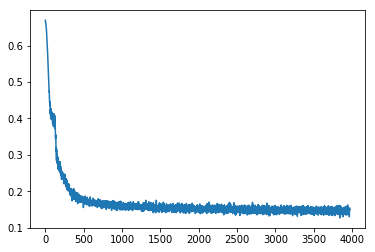

In [5]:
if __name__ == '__main__':

	#create the output image directory
	if (os.path.isdir('images')==0):
		os.mkdir('images')

	#choose dataset
	dataset_name = 'mnist'#

	#create AE model
	architecture = 'convolutional'#'mlp'#'convolutional'#
	ae_conv = autoencoder(dataset_name,architecture)#,

	ae_conv.train(epochs=ae_conv.epochs, batch_size=64, sample_interval=100)
	plt.plot(ae_conv.error_list[30:])
	plt.show()

***
# Evaluation on some images of the dataset

## Don't forget to switch `noise` to True if needed

In [8]:
noise = False

n_images = 5
(X_train, _), (_, _) = mnist.load_data()
X_train = np.expand_dims(X_train, axis=3)
X_train = X_train/255.0

if noise:
    noise = np.expand_dims(np.random.normal(scale=20/255, size=(n_images,X_train.shape[1],X_train.shape[2])),
                                   axis=3)
    idx = np.random.randint(0, X_train.shape[0], n_images)
    test_imgs = X_train[idx,:,:,:] + noise
else:
    idx = np.random.randint(0, X_train.shape[0], n_images)
    test_imgs = X_train[idx,:,:,:]
    
n_images = test_imgs.shape[0]
ae_mlp, ae_conv = load_model('ae_mlp.h5'), load_model('ae_convolutional.h5')
output_imgs1 = ae_mlp.predict(test_imgs)
output_imgs2 = ae_conv.predict(test_imgs)

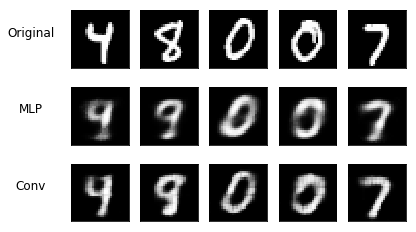

In [9]:
from matplotlib import rcParams
rcParams['axes.labelpad'] = 40 
r = 3
c = n_images
fig, axs = plt.subplots(r, c)
#fig.set_figheight(15)
#fig.set_figwidth(15)
for j in range(c):
    axs[0,j].imshow(test_imgs[j, :,:,0], cmap='gray')
    axs[0,j].set_xticks([])
    axs[0,j].set_yticks([])
    axs[1,j].imshow(output_imgs1[j, :,:,0], cmap='gray')
    axs[1,j].set_xticks([])
    axs[1,j].set_yticks([])
    axs[2,j].imshow(output_imgs2[j, :,:,0], cmap='gray')
    axs[2,j].set_xticks([])
    axs[2,j].set_yticks([])

axs[0,0].set_ylabel('Original', rotation=0, size='large')
axs[1,0].set_ylabel('MLP', rotation=0, size='large')
axs[2,0].set_ylabel('Conv', rotation=0, size='large')

#fig.tight_layout()
plt.savefig('results_z10.eps', bbox_inches='tight')
plt.show()

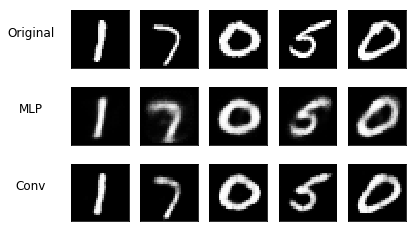

In [22]:
from matplotlib import rcParams
rcParams['axes.labelpad'] = 40 
r = 3
c = n_images
fig, axs = plt.subplots(r, c)
#fig.set_figheight(15)
#fig.set_figwidth(15)
for j in range(c):
    axs[0,j].imshow(test_imgs[j, :,:,0], cmap='gray')
    axs[0,j].set_xticks([])
    axs[0,j].set_yticks([])
    axs[1,j].imshow(output_imgs1[j, :,:,0], cmap='gray')
    axs[1,j].set_xticks([])
    axs[1,j].set_yticks([])
    axs[2,j].imshow(output_imgs2[j, :,:,0], cmap='gray')
    axs[2,j].set_xticks([])
    axs[2,j].set_yticks([])

axs[0,0].set_ylabel('Original', rotation=0, size='large')
axs[1,0].set_ylabel('MLP', rotation=0, size='large')
axs[2,0].set_ylabel('Conv', rotation=0, size='large')

#fig.tight_layout()
plt.savefig('results_z100.eps', bbox_inches='tight')
plt.show()

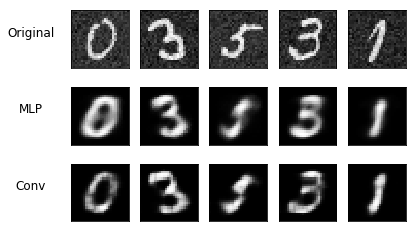

In [50]:
from matplotlib import rcParams
rcParams['axes.labelpad'] = 40 
r = 3
c = n_images
fig, axs = plt.subplots(r, c)
#fig.set_figheight(15)
#fig.set_figwidth(15)
for j in range(c):
    axs[0,j].imshow(test_imgs[j, :,:,0], cmap='gray')
    axs[0,j].set_xticks([])
    axs[0,j].set_yticks([])
    axs[1,j].imshow(output_imgs1[j, :,:,0], cmap='gray')
    axs[1,j].set_xticks([])
    axs[1,j].set_yticks([])
    axs[2,j].imshow(output_imgs2[j, :,:,0], cmap='gray')
    axs[2,j].set_xticks([])
    axs[2,j].set_yticks([])

axs[0,0].set_ylabel('Original', rotation=0, size='large')
axs[1,0].set_ylabel('MLP', rotation=0, size='large')
axs[2,0].set_ylabel('Conv', rotation=0, size='large')

#fig.tight_layout()
plt.savefig('results_z10_noisy.eps', bbox_inches='tight')
plt.show()

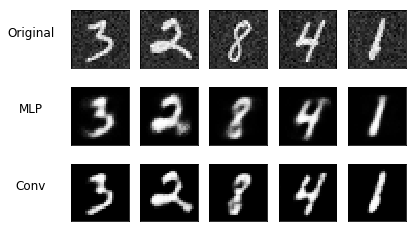

In [55]:
from matplotlib import rcParams
rcParams['axes.labelpad'] = 40 
r = 3
c = n_images
fig, axs = plt.subplots(r, c)
#fig.set_figheight(15)
#fig.set_figwidth(15)
for j in range(c):
    axs[0,j].imshow(test_imgs[j, :,:,0], cmap='gray')
    axs[0,j].set_xticks([])
    axs[0,j].set_yticks([])
    axs[1,j].imshow(output_imgs1[j, :,:,0], cmap='gray')
    axs[1,j].set_xticks([])
    axs[1,j].set_yticks([])
    axs[2,j].imshow(output_imgs2[j, :,:,0], cmap='gray')
    axs[2,j].set_xticks([])
    axs[2,j].set_yticks([])

axs[0,0].set_ylabel('Original', rotation=0, size='large')
axs[1,0].set_ylabel('MLP', rotation=0, size='large')
axs[2,0].set_ylabel('Conv', rotation=0, size='large')

#fig.tight_layout()
plt.savefig('results_z100_noisy.eps', bbox_inches='tight')
plt.show()